In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull
from numpy.linalg import eigvalsh
from tqdm.notebook import tqdm

from sklearn.cluster import DBSCAN
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

import onnxruntime as ort

from modelos import MDGF_DBSCAN, MDG_DBSCAN

random_seed = 9

In [2]:
dataset_folder = 'nuScenes'

df = pd.read_csv(dataset_folder + "/radar_points_with_annotations_and_noise.csv")
df.head()

,sample_token,radar_channel,num_sample,timestamp,utc_timestamp,scene_name,file_name,x_radar,y_radar,z_radar,...,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms,annotation,annotation_token,instance_token
0,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,8.4,-5.3,0.0,...,3.0,19.0,19.0,0.0,1.0,17.0,3.0,noise,NaN,NaN
1,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,6.4,-10.5,0.0,...,3.0,19.0,19.0,0.0,1.0,19.0,3.0,noise,NaN,NaN
2,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,9.4,-9.9,0.0,...,3.0,20.0,20.0,0.0,1.0,18.0,3.0,noise,NaN,NaN
3,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,14.6,2.3,0.0,...,3.0,19.0,19.0,0.0,1.0,16.0,3.0,noise,NaN,NaN
4,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,15.0,7.5,0.0,...,3.0,19.0,19.0,0.0,1.0,16.0,3.0,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6


In [3]:
df.columns

Index(['sample_token', 'radar_channel', 'num_sample', 'timestamp',
       'utc_timestamp', 'scene_name', 'file_name', 'x_radar', 'y_radar',
       'z_radar', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp',
       'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state',
       'pdh0', 'vx_rms', 'vy_rms', 'annotation', 'annotation_token',
       'instance_token'],
      dtype='object')

In [4]:
feature_subset = [
    'n_points', 'distance_to_origin', 
    'x_mean', 'y_mean', 'z_mean',
    'x_spread', 'y_spread', 'z_spread',
    'bbox_area_xy', 'bbox_volume',
    'speed_comp_mean', 'speed_comp_std',
    'rcs_mean', 'rcs_std',
    'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy',
    'convex_hull_area', 'point_density_xy', 'circularity',
    'flatness', 'linearity', 'sphericity',
    'stationary_ratio', 'quality_valid_ratio'
]

group_classes = {
    "Car": ["vehicle.car"],
    "Large Vehicles": [
        "vehicle.truck", "vehicle.bus", "vehicle.bus.bendy", "vehicle.bus.rigid",
        "vehicle.emergency.ambulance", "vehicle.construction", "vehicle.trailer"
    ],
    "Twowheels": ["vehicle.motorcycle", "vehicle.bicycle"],
    "Pedestrian": [
        "human.pedestrian.adult", "human.pedestrian.child", "human.pedestrian.construction_worker",
        "human.pedestrian.police_officer", "human.pedestrian.wheelchair"
    ],
    "Noise": ["noise"]
}

annotation_to_group = {}
for group, annots in group_classes.items():
    for annot in annots:
        annotation_to_group[annot] = group

def map_annotation(annotation):
    return annotation_to_group.get(annotation, "Other")

df['grouped_annotation'] = df['annotation'].apply(map_annotation)

In [5]:
# Split features and labels
X = df.values
y = df['grouped_annotation'].values

# Split into train, valid, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp)

# Normalize only numeric columns
numeric_cols = ['x_radar', 'y_radar', 'z_radar', 'dyn_prop', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'x_rms', 'y_rms', 'vx_rms', 'vy_rms']
scaler = MinMaxScaler()
X_train_norm_numeric = scaler.fit_transform(X_train[:, [df.columns.get_loc(col) for col in numeric_cols]])
X_valid_norm_numeric = scaler.transform(X_valid[:, [df.columns.get_loc(col) for col in numeric_cols]])
X_test_norm_numeric = scaler.transform(X_test[:, [df.columns.get_loc(col) for col in numeric_cols]])

# Convert normalized numeric columns to DataFrame
X_train_norm_df = pd.DataFrame(X_train_norm_numeric, columns=numeric_cols, index=None)
X_valid_norm_df = pd.DataFrame(X_valid_norm_numeric, columns=numeric_cols, index=None)
X_test_norm_df = pd.DataFrame(X_test_norm_numeric, columns=numeric_cols, index=None)

# Get non-numeric columns
non_numeric_cols = [col for col in df.columns if col not in numeric_cols]

# Concatenate normalized numeric columns with non-numeric columns
X_train_full = pd.concat([X_train_norm_df, pd.DataFrame(X_train[:, [df.columns.get_loc(col) for col in non_numeric_cols]], columns=non_numeric_cols)], axis=1)
X_valid_full = pd.concat([X_valid_norm_df, pd.DataFrame(X_valid[:, [df.columns.get_loc(col) for col in non_numeric_cols]], columns=non_numeric_cols)], axis=1)
X_test_full = pd.concat([X_test_norm_df, pd.DataFrame(X_test[:, [df.columns.get_loc(col) for col in non_numeric_cols]], columns=non_numeric_cols)], axis=1)


X_train_full.head()

,x_radar,y_radar,z_radar,dyn_prop,rcs,vx,vy,vx_comp,vy_comp,x_rms,...,file_name,id,is_quality_valid,ambig_state,invalid_state,pdh0,annotation,annotation_token,instance_token,grouped_annotation
0,0.158878,0.408602,0.0,0.166667,0.657895,0.630153,0.473581,0.677796,0.446520,0.000000,...,samples/RADAR_BACK_RIGHT/n015-2018-08-03-15-00...,36.0,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise
1,0.211838,0.597263,0.0,0.500000,0.166667,0.583039,0.452055,0.679534,0.451646,0.166667,...,samples/RADAR_FRONT/n015-2018-07-18-11-41-49+0...,101.0,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise
2,0.163551,0.466276,0.0,0.166667,0.201754,0.573616,0.481409,0.676996,0.448029,0.000000,...,samples/RADAR_FRONT/n008-2018-09-18-12-53-31-0...,46.0,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise
3,0.091121,0.440860,0.0,0.166667,0.114035,0.628975,0.500978,0.676967,0.447717,0.000000,...,samples/RADAR_BACK_LEFT/n008-2018-09-18-14-54-...,31.0,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise
4,0.198598,0.460411,0.0,0.166667,0.350877,0.555948,0.502935,0.675801,0.448660,0.000000,...,samples/RADAR_FRONT/n008-2018-08-06-15-06-32-0...,77.0,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise


---

In [6]:
X_train_full_copy = X_train_full.copy()
X_train_full_copy['cluster_id'] = -1
X_train_full_copy['cluster_majority_class'] = None

X_train_full_grouped = X_train_full_copy.groupby(['timestamp', 'radar_channel'])
X_train_full_grouped.size()

timestamp         radar_channel    
1526915243022952  RADAR_BACK_RIGHT     27
1526915243042374  RADAR_FRONT          38
1526915243057699  RADAR_BACK_LEFT      34
1526915243062454  RADAR_FRONT_RIGHT     4
1526915243072140  RADAR_FRONT_LEFT     19
                                       ..
1542801733413753  RADAR_BACK_RIGHT     33
1542801733414038  RADAR_FRONT_RIGHT     7
1542801733419744  RADAR_FRONT          51
1542801733446609  RADAR_FRONT_LEFT     14
1542801733479411  RADAR_BACK_LEFT      34
Length: 166286, dtype: int64

In [56]:
# for (timestamp, radar_channel), group in tqdm(X_train_full_grouped):
#     if len(group) < 1:
#         continue
#     X = group[['x_radar', 'y_radar', 'rcs', 'vx', 'vy']].values
#     dbscan = DBSCAN(eps=0.5, min_samples=2)
#     cluster_labels = dbscan.fit_predict(X)
    
#     # Map annotations to group classes
#     group_labels = group['annotation'].map(map_annotation)
    
#     # Assign cluster labels to the original dataframe
#     idx = group.index
#     X_train_full_copy.loc[idx, 'cluster_id'] = cluster_labels

#     # Assign majority class per cluster
#     for cluster_id in np.unique(cluster_labels):
#         cluster_indices = group.index[cluster_labels == cluster_id]
#         majority_class = group_labels[cluster_labels == cluster_id].mode()
#         if not majority_class.empty:
#             X_train_full_copy.loc[cluster_indices, 'cluster_majority_class'] = majority_class.iloc[0]
        

In [57]:
# for (timestamp, radar_channel), group in tqdm(X_train_full_grouped):
#     if len(group) < 1:
#         continue
#     # Prepare data for MDGF_DBSCAN
#     X = group[['x_radar', 'y_radar', 'rcs', 'vx', 'vy']].values
#     points = [MDGF_DBSCAN.Point(d, index=i) for i, d in enumerate(X)]
#     eps = np.array([0.5, 0.5, 0.5, 0.5, 0.5])  # Example: tune per feature

#     # Run MDGF_DBSCAN
#     cluster_labels, _ = MDGF_DBSCAN.MDGF_DBSCAN(points, eps, alpha=0.5, k=1.0)

#     # Map annotations to group classes
#     group_labels = group['annotation'].map(map_annotation)

#     # Assign cluster labels to the original dataframe
#     idx = group.index
#     X_train_full_copy.loc[idx, 'cluster_id'] = cluster_labels

#     # Assign majority class per cluster
#     for cluster_id in np.unique(cluster_labels):
#         cluster_indices = group.index[cluster_labels == cluster_id]
#         majority_class = group_labels[cluster_labels == cluster_id].mode()
#         if not majority_class.empty:
#             X_train_full_copy.loc[cluster_indices, 'cluster_majority_class'] = majority_class.iloc[0]

In [15]:
for (timestamp, radar_channel), group in tqdm(X_train_full_grouped):
    if len(group) < 1:
        continue
    # Prepare data for MDG_DBSCAN
    X = group[['x_radar', 'y_radar', 'rcs', 'vx', 'vy']].values
    points, cluster_labels = MDG_DBSCAN.getPoint(X)
    eps = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Tune per feature

    # Run MDG_DBSCAN
    cluster_labels = MDG_DBSCAN.gdb_scan(points, cluster_labels, eps)

    # Map annotations to group classes
    group_labels = group['annotation'].map(map_annotation)

    # Assign cluster labels to the original dataframe
    idx = group.index
    X_train_full_copy.loc[idx, 'cluster_id'] = cluster_labels

    # Assign majority class per cluster (ignore "Noise" unless cluster is only Noise)
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = (cluster_labels == cluster_id)
        cluster_indices = group.index[cluster_mask]

        classes_in_cluster = group_labels[cluster_mask]
        non_noise_classes = classes_in_cluster[classes_in_cluster != 'Noise']

        if not non_noise_classes.empty:
            maj = non_noise_classes.mode()
            if not maj.empty:
                X_train_full_copy.loc[cluster_indices, 'cluster_majority_class'] = maj.iloc[0]
        else:
            # Only noise points in this cluster
            X_train_full_copy.loc[cluster_indices, 'cluster_majority_class'] = 'Noise'

  0%|          | 0/166286 [00:00<?, ?it/s]

In [31]:
# Drop rows labeled as 'Noise' and show updated class counts
X_train_full_copy = X_train_full_copy[X_train_full_copy['cluster_majority_class'] != 'Noise'].copy()

X_train_full_copy['cluster_majority_class'].value_counts()

cluster_majority_class
Car               1498078
Large Vehicles     695510
Other              144992
Pedestrian          64558
Twowheels           24335
Name: count, dtype: int64

In [32]:
X_train_full_copy.columns

Index(['x_radar', 'y_radar', 'z_radar', 'dyn_prop', 'rcs', 'vx', 'vy',
       'vx_comp', 'vy_comp', 'x_rms', 'y_rms', 'vx_rms', 'vy_rms',
       'sample_token', 'radar_channel', 'num_sample', 'timestamp',
       'utc_timestamp', 'scene_name', 'file_name', 'id', 'is_quality_valid',
       'ambig_state', 'invalid_state', 'pdh0', 'annotation',
       'annotation_token', 'instance_token', 'grouped_annotation',
       'cluster_id', 'cluster_majority_class'],
      dtype='object')

In [33]:
X_train_full_copy.head()

,x_radar,y_radar,z_radar,dyn_prop,rcs,vx,vy,vx_comp,vy_comp,x_rms,...,is_quality_valid,ambig_state,invalid_state,pdh0,annotation,annotation_token,instance_token,grouped_annotation,cluster_id,cluster_majority_class
1,0.211838,0.597263,0.0,0.500000,0.166667,0.583039,0.452055,0.679534,0.451646,0.166667,...,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise,0,Large Vehicles
2,0.163551,0.466276,0.0,0.166667,0.201754,0.573616,0.481409,0.676996,0.448029,0.000000,...,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise,0,Car
3,0.091121,0.440860,0.0,0.166667,0.114035,0.628975,0.500978,0.676967,0.447717,0.000000,...,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise,0,Car
5,0.258567,0.589443,0.0,0.166667,0.324561,0.648999,0.497065,0.676563,0.448096,0.000000,...,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise,0,Large Vehicles
6,0.217290,0.446725,0.0,0.166667,0.219298,0.643110,0.628180,0.678117,0.447274,0.000000,...,1.0,3.0,0.0,1.0,noise,NaN,NaN,Noise,0,Car


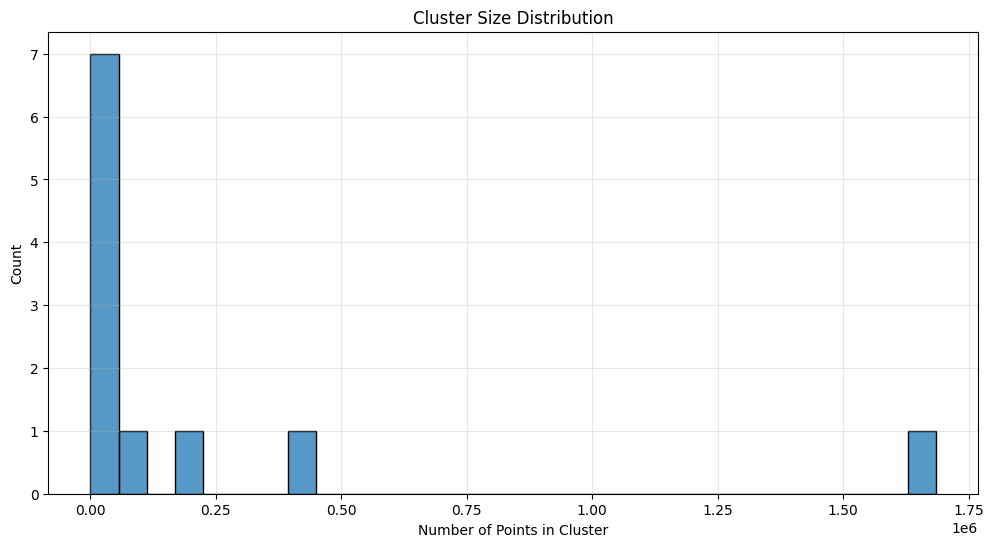

/tmp/ipykernel_33755/553412398.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_clusters))


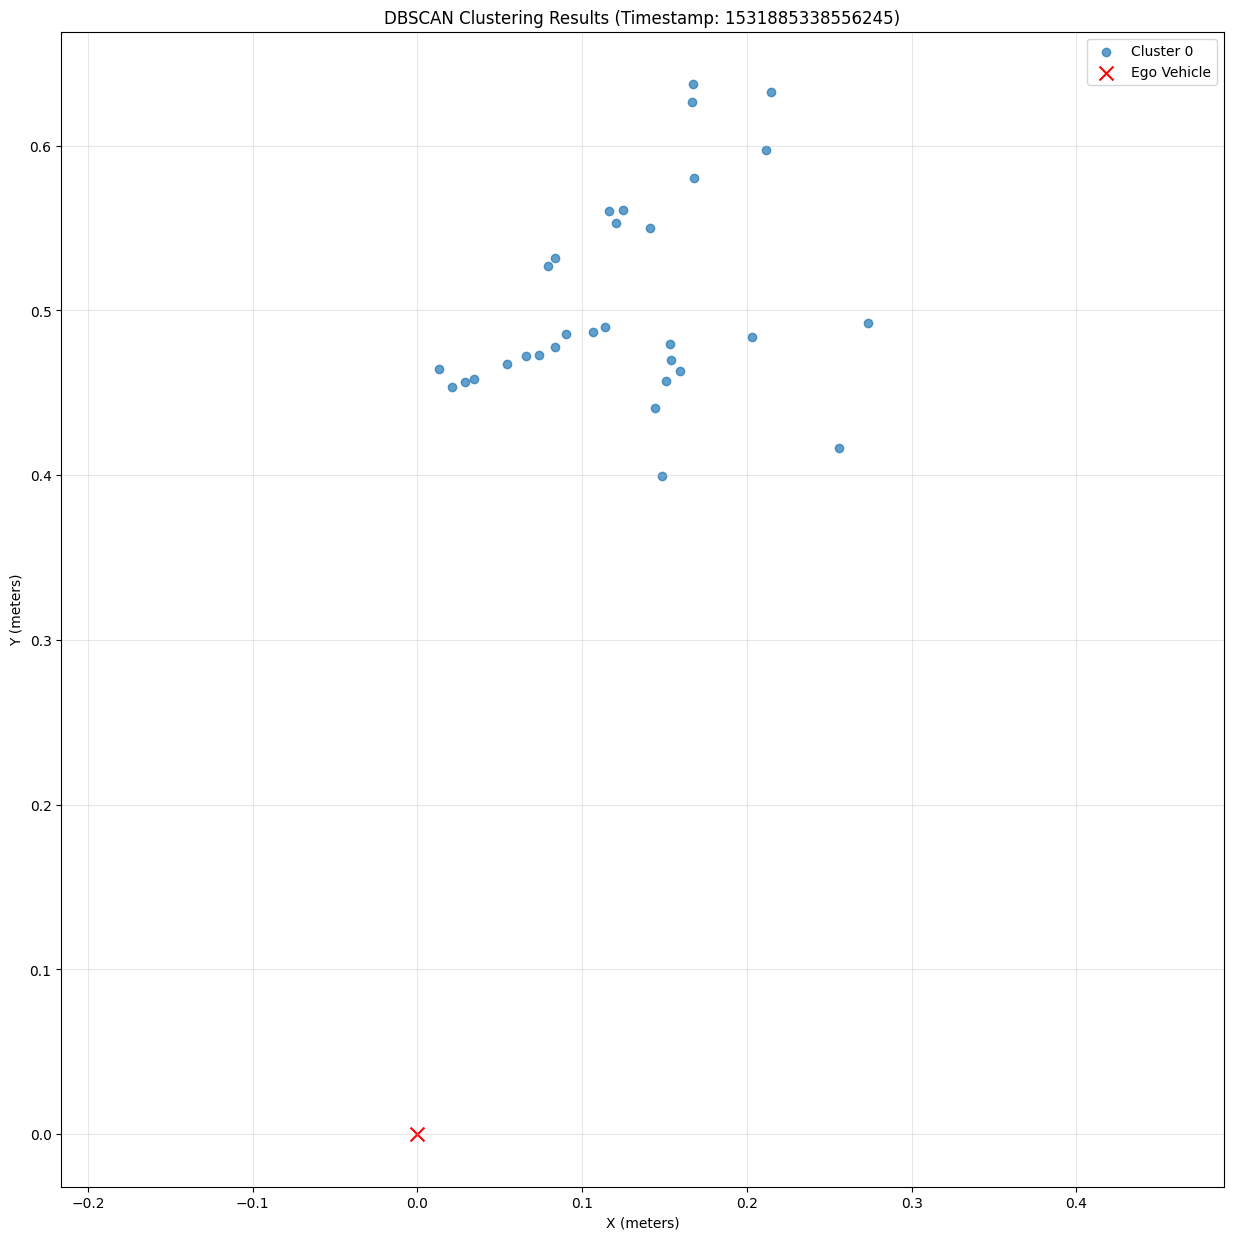

In [35]:
# Check if clustering was performed
if 'X_train_full_copy' in locals():
    # Count the number of points in each cluster
    cluster_sizes = X_train_full_copy[X_train_full_copy['cluster_id'] != -1]['cluster_id'].value_counts()
    
    # Plot cluster size distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(cluster_sizes, bins=30)
    plt.title('Cluster Size Distribution')
    plt.xlabel('Number of Points in Cluster')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualize a sample of clusters in 2D (top view)
    plt.figure(figsize=(15, 15))
    
    # Get unique timestamps
    timestamps = X_train_full_copy['timestamp'].unique()
    sample_timestamp = timestamps[0]  # Just take the first timestamp
    
    # Filter data for the selected timestamp
    sample_data = X_train_full_copy[X_train_full_copy['timestamp'] == sample_timestamp]
    
    # Create a colormap for the clusters
    unique_clusters = sample_data['cluster_id'].unique()
    cmap = plt.cm.get_cmap('tab20', len(unique_clusters))
    
    # Plot each cluster with a different color
    for i, cluster_id in enumerate(unique_clusters):
        if cluster_id == -1:  # Noise points in black
            cluster_points = sample_data[sample_data['cluster_id'] == cluster_id]
            plt.scatter(cluster_points['x_radar'], cluster_points['y_radar'], 
                        c='black', marker='.', alpha=0.5, label='Noise')
        else:
            cluster_points = sample_data[sample_data['cluster_id'] == cluster_id]
            plt.scatter(cluster_points['x_radar'], cluster_points['y_radar'], 
                        c=[cmap(i)], marker='o', alpha=0.7, label=f'Cluster {cluster_id}')
    
    plt.title(f'DBSCAN Clustering Results (Timestamp: {sample_timestamp})')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')  # Equal aspect ratio
    
    # Add ego vehicle position marker at (0,0)
    plt.scatter([0], [0], c='red', marker='x', s=100, label='Ego Vehicle')
    
    # Create a custom legend with fewer entries
    handles, labels = plt.gca().get_legend_handles_labels()
    max_legend_entries = 10  # Limit the number of legend entries
    if len(handles) > max_legend_entries:
        handles = [handles[0]] + handles[1:max_legend_entries]
        labels = [labels[0]] + labels[1:max_legend_entries] + ['...']
    plt.legend(handles, labels, loc='upper right')
    
    plt.show()

# Show feature distribution
if 'X_train_full_copy' in locals():
    # Visualize class distribution if available
    if 'class_group' in X_train_full_copy.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(x='class_group', data=X_train_full_copy)
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Show distribution of important features
    important_features = [
        'n_points', 'distance_to_origin', 'rcs_mean', 
        'speed_comp_mean', 'convex_hull_area', 'point_density_xy'
    ]
    
    available_features = [f for f in important_features if f in X_train_full_copy.columns]
    
    if available_features:
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(available_features):
            plt.subplot(2, 3, i+1)
            sns.histplot(X_train_full_copy[feature], kde=True)
            plt.title(f'Distribution of {feature}')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Correlation matrix of features
    if 'n_points' in X_train_full_copy.columns:
        numeric_features = X_train_full_copy.select_dtypes(include=[np.number]).columns
        feature_subset = [f for f in numeric_features if f not in ['cluster_id', 'timestamp']][:10]
        
        plt.figure(figsize=(12, 10))
        corr_matrix = X_train_full_copy[feature_subset].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

In [36]:
from cluster_metrics import ClusterMetrics
from collections import Counter, defaultdict

def f1_score_cluster(labels_true, labels_pred):
    """
    Calcula precisão, revocação e F1-score globais para clustering com rótulos conhecidos.
    
    Retorna:
    p : precisão global
    r : recall global
    f1: F1-score global
    """
    
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)
    
    # Matriz de contingência (linhas = GT, colunas = Pred)
    conf_mat = np.zeros((len(unique_true), len(unique_pred)), dtype=int)
    for i, t in enumerate(unique_true):
        for j, p_val in enumerate(unique_pred):
            conf_mat[i, j] = np.sum((labels_true == t) & (labels_pred == p_val))
    
    # Correspondência ótima (Hungarian Algorithm)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)  # maximizar correspondência
    
    tp_total = 0
    fp_total = 0
    fn_total = 0
    
    for r_idx, c_idx in zip(row_ind, col_ind):
        tp = conf_mat[r_idx, c_idx]
        fp = conf_mat[:, c_idx].sum() - tp
        fn = conf_mat[r_idx, :].sum() - tp
        
        tp_total += tp
        fp_total += fp
        fn_total += fn
    
    # Cálculo global
    p = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
    r = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    
    return p, r, f1


def compute_metrics(sample, algoritmo, eps, min_points, runTime, peakMem, labels_true, labels_pred):
    # Calcula ARI, NMI e F1-score para clustering com rótulos conhecidos.
    NMI = normalized_mutual_info_score(labels_true, labels_pred)
    ARI = adjusted_rand_score(labels_true, labels_pred)
    p, r, f1 = f1_score_cluster(labels_true, labels_pred)

    labels_arr = np.array(labels_pred)
    qty_outliers = np.sum(labels_arr == -1)
    qty_clusters = len(set(labels_arr) - {-1})
    qty_clusters_true = len(set(labels_true))

    # Implementa o índice baseado no mapeamento cluster -> lista de rótulos verdadeiros
    # usando apenas os parâmetros da função.

    # Contagem de classes globais (remove -1 e -2 se estiverem presentes)
    classes_count = Counter([c for c in labels_true if c not in (-1, -2)])

    # Constrói mapeamento: valor de labels_pred (cluster/label previsto) -> lista de labels_true
    mapeamento = defaultdict(list)
    for t, p_val in zip(labels_true, labels_pred):
        mapeamento[p_val].append(t)

    cluster_curr = []
    for classes in mapeamento.values():
        # Remove noise (-1) e inválidos (-2)
        valid_classes = [c for c in classes if c not in (-1, -2)]
        if not valid_classes:
            continue

        major_class = max(set(valid_classes), key=valid_classes.count)
        if major_class in classes_count and classes_count[major_class] > 0:
            cluster_count = valid_classes.count(major_class)
            cluster_curr.append(cluster_count / classes_count[major_class])

    matching_index = float(np.mean(cluster_curr)) if cluster_curr else 0.0

    metrics_data = {
        "num_sample": [sample],
        "algorithm": [algoritmo],
        "eps": [eps],
        "min_points": [min_points],
        "qty_clusters_true": [qty_clusters_true],
        "qty_cluster": [qty_clusters],
        "qty_outliers": [qty_outliers],
        "runTime": [runTime],
        "peakMem": [peakMem],
        "ARI": [ARI],
        "NMI": [NMI],
        "p": [p],
        "r": [r],
        "f1": [f1],
        "matching_index": [matching_index],
        "labels_true": [labels_true],
        "labels_pred": [labels_pred]
    }
    df_metrics = pd.DataFrame(metrics_data)

    return df_metrics

# Compute clustering metrics for the extracted clusters
metrics_df = compute_metrics(
    sample="full_train",
    algoritmo="DBSCAN",
    eps=0.1,
    min_points=2,
    runTime=None,
    peakMem=None,
    labels_true=X_train_full_copy['grouped_annotation'],
    labels_pred=X_train_full_copy['cluster_majority_class']
)

metrics_df

,num_sample,algorithm,eps,min_points,qty_clusters_true,qty_cluster,qty_outliers,runTime,peakMem,ARI,NMI,p,r,f1,matching_index,labels_true,labels_pred
0,full_train,DBSCAN,0.1,2,6,5,0,None,None,0.020241,0.107407,0.568118,0.633766,0.599149,0.2,1 Noise 2 Noise 3 N...,1 Large Vehicles 2 ...


---

In [38]:
def compute_cluster_features(cluster):
    """
    Compute statistical features for a cluster of radar points.
    Only calculates features in feature_subset.
    Args:
        cluster (DataFrame): Cluster of radar points with the same timestamp and instance_token
    Returns:
        dict: Dictionary of computed features
    """
    features = {}

    # Basic count feature
    features['n_points'] = len(cluster)

    # Position features
    if 'x_radar' in cluster.columns and 'y_radar' in cluster.columns and 'z_radar' in cluster.columns:
        x = cluster['x_radar']
        y = cluster['y_radar']
        z = cluster['z_radar']

        features['x_mean'] = x.mean()
        features['y_mean'] = y.mean()
        features['z_mean'] = z.mean()

        features['x_spread'] = x.max() - x.min()
        features['y_spread'] = y.max() - y.min()
        features['z_spread'] = z.max() - z.min()

        # Distance to origin (ego vehicle)
        centroid_x = features['x_mean']
        centroid_y = features['y_mean']
        centroid_z = features['z_mean']
        features['distance_to_origin'] = np.sqrt(centroid_x**2 + centroid_y**2 + centroid_z**2)

        # Bounding box features
        features['bbox_area_xy'] = features['x_spread'] * features['y_spread']
        features['bbox_volume'] = features['x_spread'] * features['y_spread'] * features['z_spread']

        # Covariance and shape features (xy plane)
        if len(x) >= 3:
            xy = np.vstack((x, y)).T
            cov_xy = np.cov(xy, rowvar=False)
            if cov_xy.shape == (2, 2):
                eigvals_xy = eigvalsh(cov_xy)
                features['cov_ev_major_xy'] = eigvals_xy[-1]
                features['cov_ev_minor_xy'] = eigvals_xy[0]
                features['cov_ev_ratio_xy'] = eigvals_xy[-1] / (eigvals_xy[0] + 1e-10)
            else:
                features['cov_ev_major_xy'] = 0
                features['cov_ev_minor_xy'] = 0
                features['cov_ev_ratio_xy'] = 0

            # Convex hull features
            try:
                hull_xy = ConvexHull(xy)
                features['convex_hull_area'] = hull_xy.volume
                features['point_density_xy'] = len(xy) / hull_xy.volume if hull_xy.volume > 0 else 0
                features['circularity'] = 4 * np.pi * hull_xy.volume / (hull_xy.area ** 2) if hull_xy.area > 0 else 0
            except:
                features['convex_hull_area'] = 0
                features['point_density_xy'] = 0
                features['circularity'] = 0

            # 3D shape features
            if len(x) >= 4:
                xyz = np.vstack((x, y, z)).T
                try:
                    cov_xyz = np.cov(xyz, rowvar=False)
                    if cov_xyz.shape == (3, 3):
                        eigvals_xyz = eigvalsh(cov_xyz)
                        features['flatness'] = (eigvals_xyz[1] - eigvals_xyz[0]) / (eigvals_xyz[2] + 1e-10)
                        features['linearity'] = (eigvals_xyz[2] - eigvals_xyz[1]) / (eigvals_xyz[2] + 1e-10)
                        features['sphericity'] = eigvals_xyz[0] / (eigvals_xyz[2] + 1e-10)
                    else:
                        features['flatness'] = 0
                        features['linearity'] = 0
                        features['sphericity'] = 0
                except:
                    features['flatness'] = 0
                    features['linearity'] = 0
                    features['sphericity'] = 0
            else:
                features['flatness'] = 0
                features['linearity'] = 0
                features['sphericity'] = 0
        else:
            features['cov_ev_major_xy'] = 0
            features['cov_ev_minor_xy'] = 0
            features['cov_ev_ratio_xy'] = 0
            features['convex_hull_area'] = 0
            features['point_density_xy'] = 0
            features['circularity'] = 0
            features['flatness'] = 0
            features['linearity'] = 0
            features['sphericity'] = 0

    # Compensated velocity features
    if 'vx_comp' in cluster.columns and 'vy_comp' in cluster.columns:
        vx_comp = cluster['vx_comp']
        vy_comp = cluster['vy_comp']
        v_comp_mag = np.sqrt(vx_comp**2 + vy_comp**2)
        features['speed_comp_mean'] = v_comp_mag.mean()
        features['speed_comp_std'] = v_comp_mag.std()
        features['stationary_ratio'] = (v_comp_mag < 0.1).mean()

    # RCS features
    if 'rcs' in cluster.columns:
        rcs = cluster['rcs']
        features['rcs_mean'] = rcs.mean()
        features['rcs_std'] = rcs.std()

    # Quality metrics if available
    if 'is_quality_valid' in cluster.columns:
        features['quality_valid_ratio'] = cluster['is_quality_valid'].mean()

    # Only return features in feature_subset
    return {k: features.get(k, 0) for k in feature_subset}


In [39]:
grouped = X_train_full_copy.groupby(['timestamp', 'radar_channel', 'cluster_id', 'cluster_majority_class'])

print(f"Found {len(grouped)} unique clusters (objects)")

print("Extracting features for each cluster...")
all_features = []
for (timestamp, radar_channel, cluster_id, cluster_majority_class), group in tqdm(grouped):
    try:
        # # Skip clusters with too few points
        # if len(group) < 3:
        #     continue
            
        features = compute_cluster_features(group)
        
        # Add identifying information
        features['cluster_id'] = cluster_id
        features['timestamp'] = timestamp
        features['radar_channel'] = radar_channel
        features['cluster_majority_class'] = cluster_majority_class

        all_features.append(features)
    except Exception as e:
        print(f"Error processing cluster ({cluster_id}, {timestamp}): {str(e)}")

# Convert all features to DataFrame
features_df = pd.DataFrame(all_features)

# Display information about the created dataset
print(f"\nCreated classification dataset with {len(features_df)} samples and {features_df.shape[1]} features")
print(f"Feature columns: {features_df.columns.tolist()}")

# Display class distribution if available
if 'annotation' in features_df.columns:
    label_counts = features_df['annotation'].value_counts()
    print("\nClass distribution:")
    print(label_counts)

# Display a sample of the dataset
print("\nSample of the dataset:")
features_df.head()

Found 165023 unique clusters (objects)
Extracting features for each cluster...


  0%|          | 0/165023 [00:00<?, ?it/s]


Created classification dataset with 165023 samples and 29 features
Feature columns: ['n_points', 'distance_to_origin', 'x_mean', 'y_mean', 'z_mean', 'x_spread', 'y_spread', 'z_spread', 'bbox_area_xy', 'bbox_volume', 'speed_comp_mean', 'speed_comp_std', 'rcs_mean', 'rcs_std', 'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy', 'convex_hull_area', 'point_density_xy', 'circularity', 'flatness', 'linearity', 'sphericity', 'stationary_ratio', 'quality_valid_ratio', 'cluster_id', 'timestamp', 'radar_channel', 'cluster_majority_class']

Sample of the dataset:


,n_points,distance_to_origin,x_mean,y_mean,z_mean,x_spread,y_spread,z_spread,bbox_area_xy,bbox_volume,...,circularity,flatness,linearity,sphericity,stationary_ratio,quality_valid_ratio,cluster_id,timestamp,radar_channel,cluster_majority_class
0,17,0.531687,0.163414,0.505951,0.0,0.353583,0.290323,0.0,0.102653,0.0,...,0.790937,0.262680,0.737320,0.0,0.0,1.0,1,1526915243022952,RADAR_BACK_RIGHT,Car
1,2,0.514750,0.120327,0.500489,0.0,0.072430,0.013685,0.0,0.000991,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,4,1526915243022952,RADAR_BACK_RIGHT,Car
2,1,0.509787,0.022586,0.509286,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,6,1526915243022952,RADAR_BACK_RIGHT,Car
3,23,0.527682,0.220676,0.479323,0.0,0.338785,0.114370,0.0,0.038747,0.0,...,0.608200,0.083349,0.916651,0.0,0.0,1.0,0,1526915243042374,RADAR_FRONT,Car
4,9,0.498804,0.040931,0.497122,0.0,0.070872,0.037146,0.0,0.002633,0.0,...,0.586704,0.223513,0.776487,0.0,0.0,1.0,0,1526915243057699,RADAR_BACK_LEFT,Car


In [40]:
missing_values = features_df.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].median())

inf_values = np.isinf(features_df.select_dtypes(include=[np.number])).sum()
print("\nColumns with infinite values:")
print(inf_values[inf_values > 0])

# Display the cleaned dataset info
print("\nCleaned dataset information:")
print(features_df.info())

print("\nBasic statistics for numerical features:")
print(features_df.describe())

Columns with missing values:
speed_comp_std    8922
rcs_std           8922
dtype: int64

Columns with infinite values:
Series([], dtype: int64)

Cleaned dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165023 entries, 0 to 165022
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   n_points                165023 non-null  int64  
 1   distance_to_origin      165023 non-null  float64
 2   x_mean                  165023 non-null  float64
 3   y_mean                  165023 non-null  float64
 4   z_mean                  165023 non-null  float64
 5   x_spread                165023 non-null  float64
 6   y_spread                165023 non-null  float64
 7   z_spread                165023 non-null  float64
 8   bbox_area_xy            165023 non-null  float64
 9   bbox_volume             165023 non-null  float64
 10  speed_comp_mean         165023 non-null  float64
 11  speed_co

In [41]:
features_df.head()

,n_points,distance_to_origin,x_mean,y_mean,z_mean,x_spread,y_spread,z_spread,bbox_area_xy,bbox_volume,...,circularity,flatness,linearity,sphericity,stationary_ratio,quality_valid_ratio,cluster_id,timestamp,radar_channel,cluster_majority_class
0,17,0.531687,0.163414,0.505951,0.0,0.353583,0.290323,0.0,0.102653,0.0,...,0.790937,0.262680,0.737320,0.0,0.0,1.0,1,1526915243022952,RADAR_BACK_RIGHT,Car
1,2,0.514750,0.120327,0.500489,0.0,0.072430,0.013685,0.0,0.000991,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,4,1526915243022952,RADAR_BACK_RIGHT,Car
2,1,0.509787,0.022586,0.509286,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,6,1526915243022952,RADAR_BACK_RIGHT,Car
3,23,0.527682,0.220676,0.479323,0.0,0.338785,0.114370,0.0,0.038747,0.0,...,0.608200,0.083349,0.916651,0.0,0.0,1.0,0,1526915243042374,RADAR_FRONT,Car
4,9,0.498804,0.040931,0.497122,0.0,0.070872,0.037146,0.0,0.002633,0.0,...,0.586704,0.223513,0.776487,0.0,0.0,1.0,0,1526915243057699,RADAR_BACK_LEFT,Car


In [42]:
features_df['cluster_majority_class'].value_counts()

cluster_majority_class
Car               98653
Large Vehicles    51355
Other              9224
Pedestrian         4298
Twowheels          1493
Name: count, dtype: int64

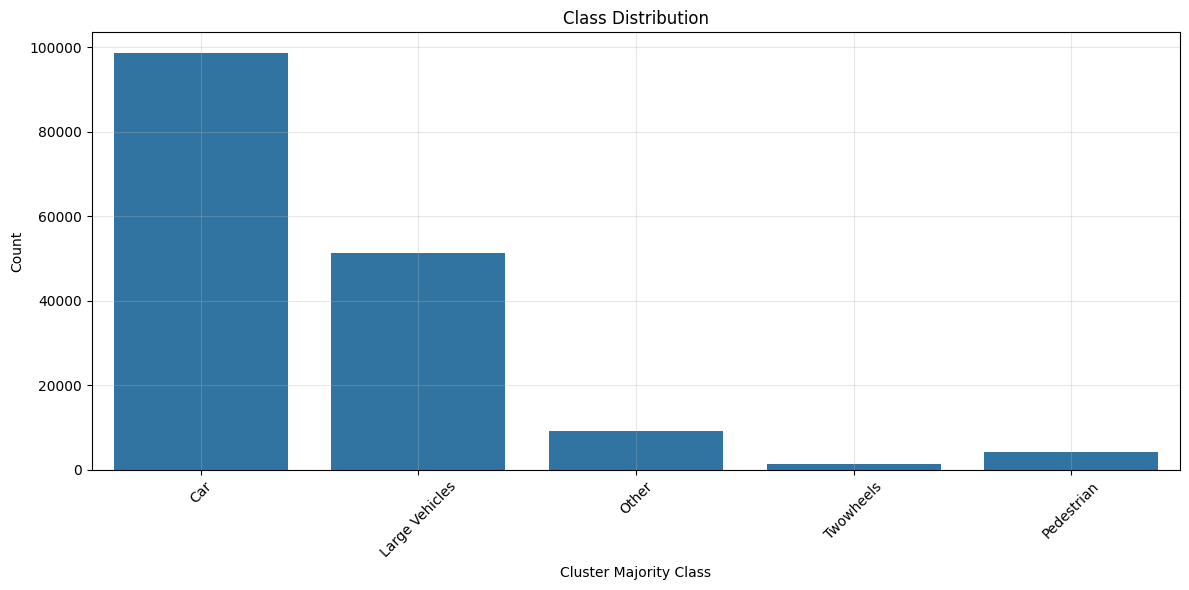

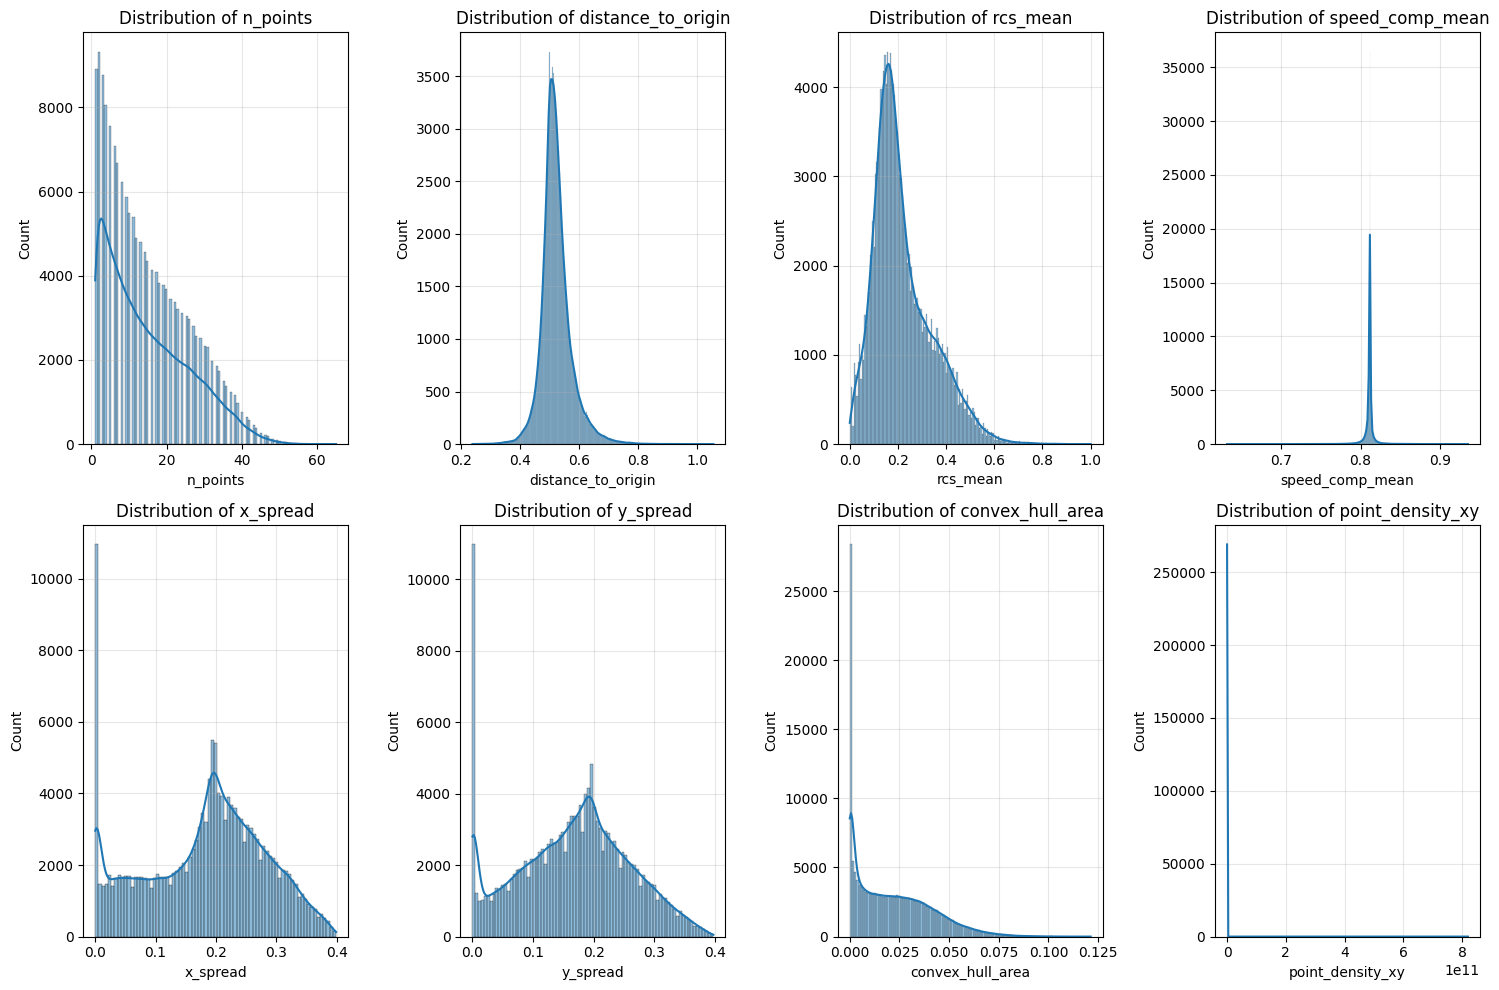

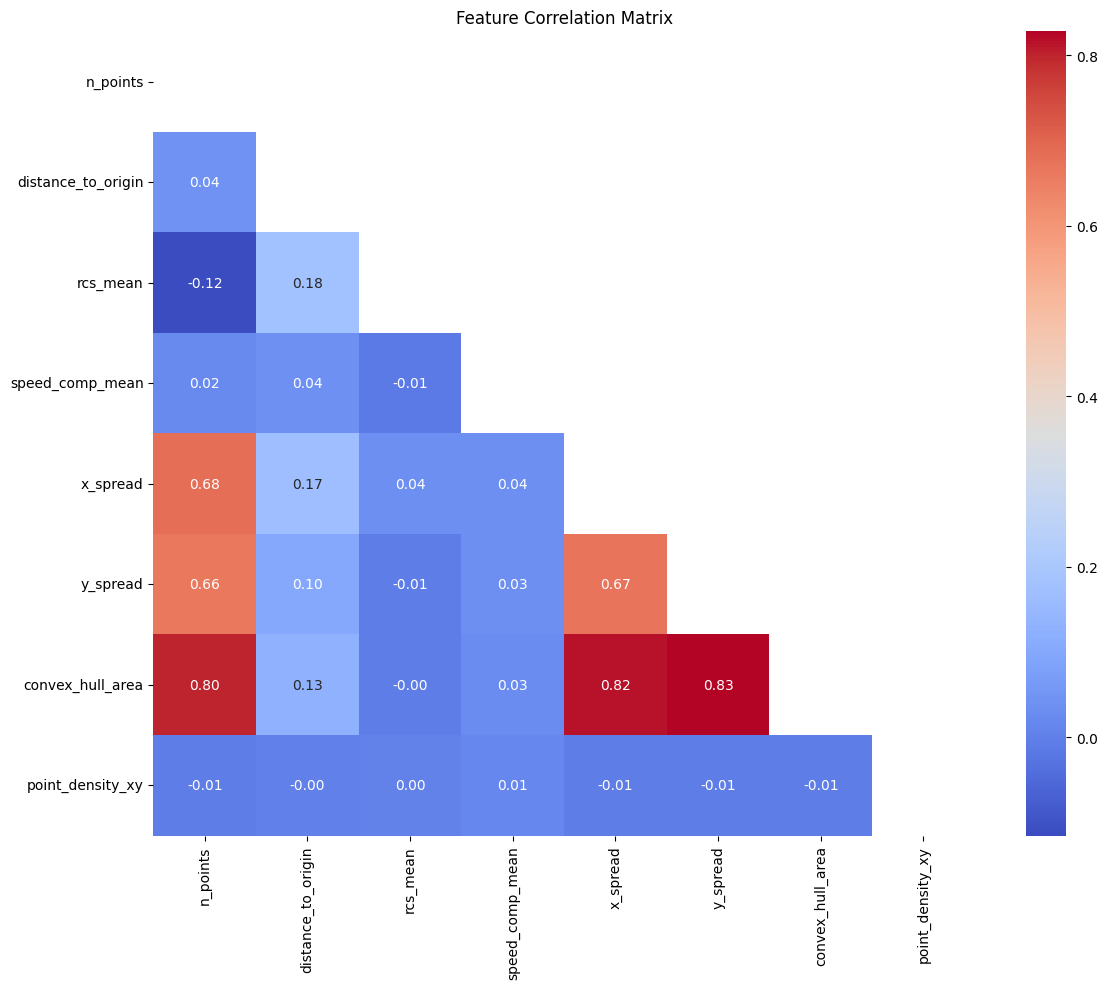

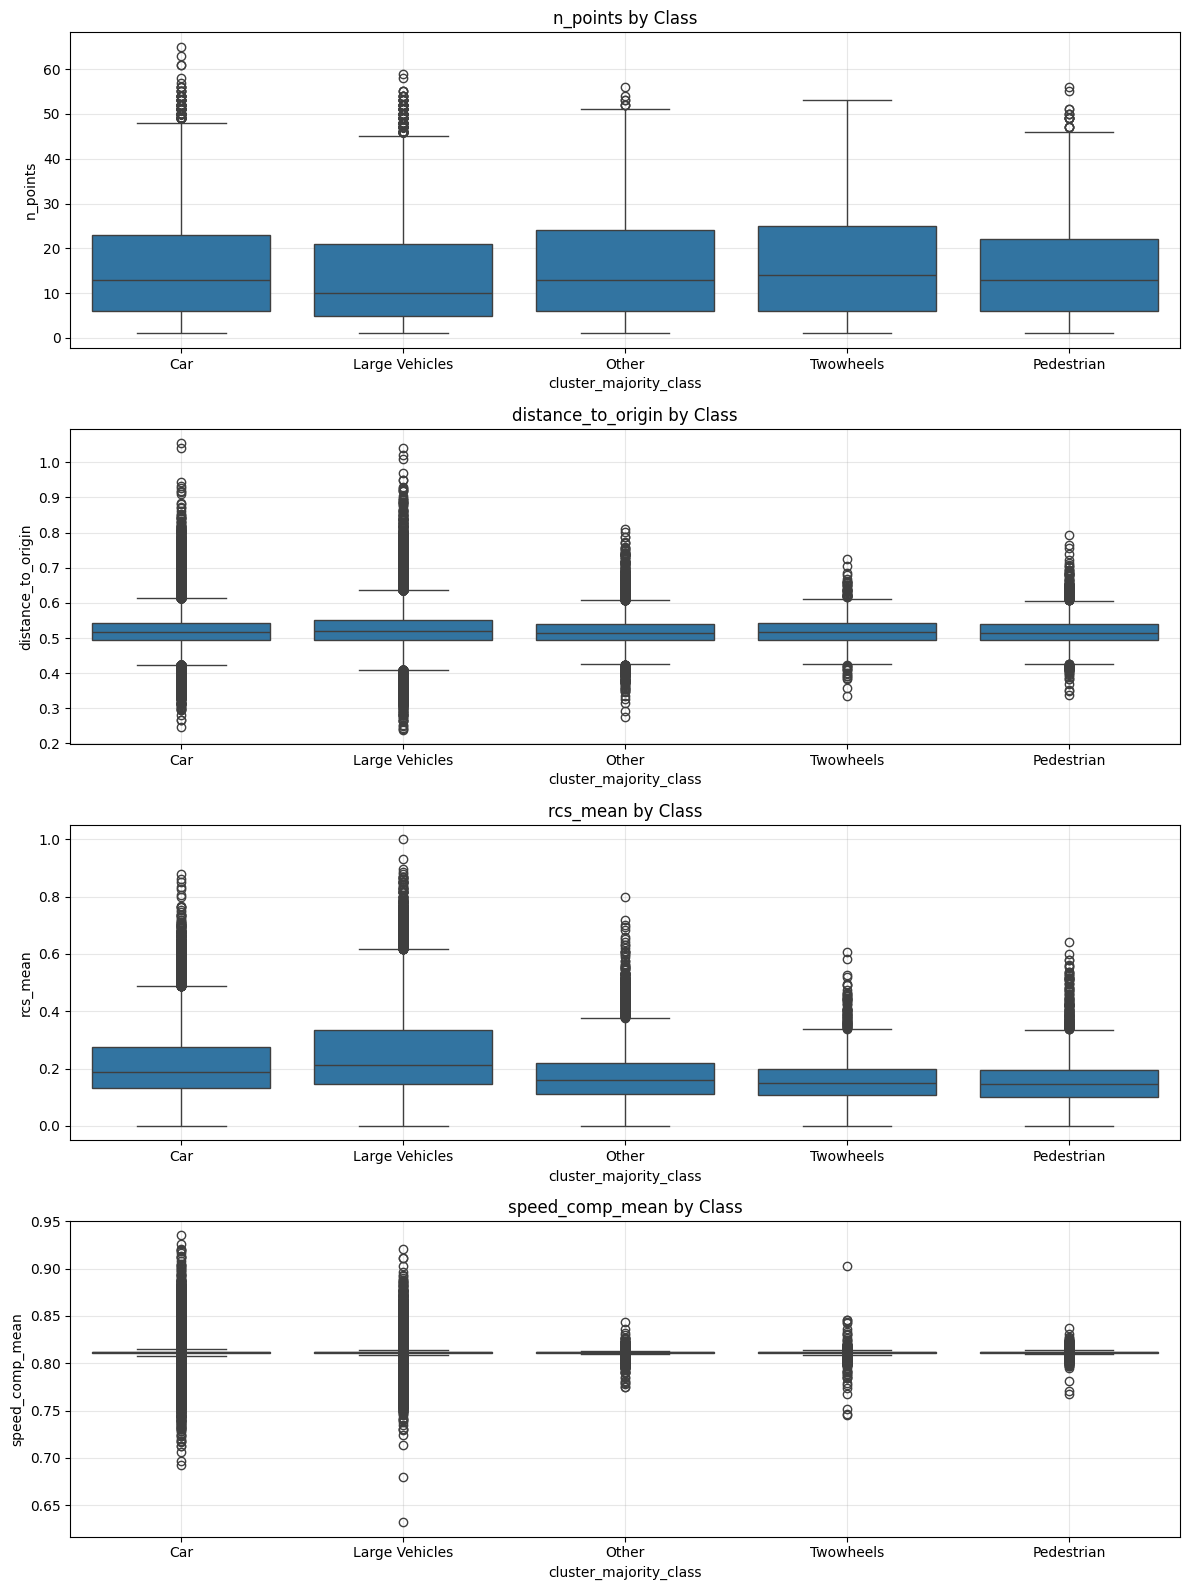

/tmp/ipykernel_33755/3393424980.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


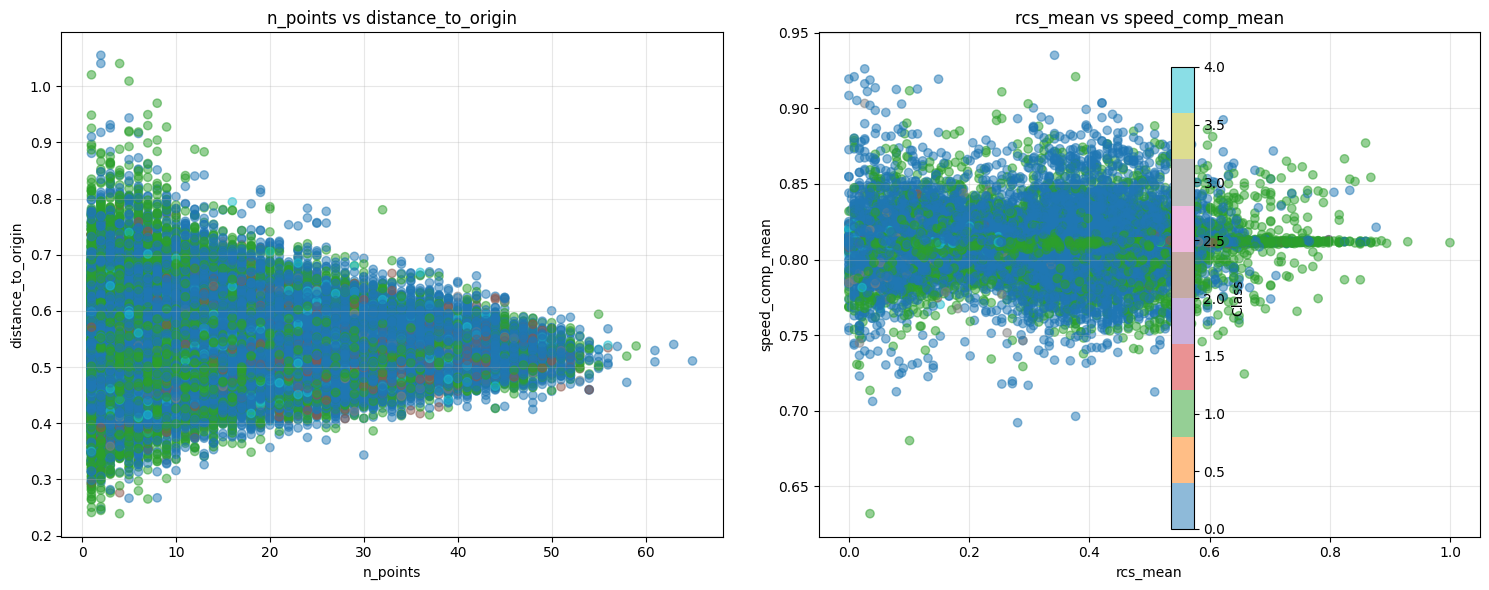

In [43]:
if 'cluster_majority_class' in features_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='cluster_majority_class', data=features_df)
    plt.title('Class Distribution')
    plt.xlabel('Cluster Majority Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

important_features = [
    'n_points', 'distance_to_origin', 'rcs_mean', 'speed_comp_mean', 
    'x_spread', 'y_spread', 'convex_hull_area', 'point_density_xy'
]

plot_features = [f for f in important_features if f in features_df.columns]

if plot_features:
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(plot_features):
        plt.subplot(2, 4, i+1)
        sns.histplot(features_df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if len(plot_features) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = features_df[plot_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

if 'cluster_majority_class' in features_df.columns and len(plot_features) > 0:
    # Get the most common classes for clarity
    top_classes = features_df['cluster_majority_class'].value_counts().head(5).index.tolist()
    df_subset = features_df[features_df['cluster_majority_class'].isin(top_classes)]
    
    # Select a smaller subset of features for clarity
    boxplot_features = plot_features[:4]  # Take first 4 features
    
    fig, axes = plt.subplots(len(boxplot_features), 1, figsize=(12, 4*len(boxplot_features)))
    
    for i, feature in enumerate(boxplot_features):
        ax = axes[i] if len(boxplot_features) > 1 else axes
        sns.boxplot(x='cluster_majority_class', y=feature, data=df_subset, ax=ax)
        ax.set_title(f'{feature} by Class')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 2D scatter plots of selected feature pairs, colored by class
if 'cluster_majority_class' in features_df.columns and len(plot_features) >= 2:
    # Use the subset with top classes for clarity
    if 'df_subset' not in locals():
        top_classes = features_df['cluster_majority_class'].value_counts().head(5).index.tolist()
        df_subset = features_df[features_df['cluster_majority_class'].isin(top_classes)]
    
    # Select a few feature pairs for visualization
    feature_pairs = [
        (plot_features[0], plot_features[1]),
        (plot_features[2], plot_features[3]) if len(plot_features) > 3 else (plot_features[0], plot_features[2])
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, (feat1, feat2) in enumerate(feature_pairs):
        scatter = axes[i].scatter(
            df_subset[feat1], 
            df_subset[feat2], 
            c=pd.factorize(df_subset['cluster_majority_class'])[0], 
            alpha=0.5, 
            cmap='tab10'
        )
        axes[i].set_xlabel(feat1)
        axes[i].set_ylabel(feat2)
        axes[i].set_title(f'{feat1} vs {feat2}')
        axes[i].grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes, label='Class')
    plt.tight_layout()
    plt.show()

---

In [44]:
# Select a subset of important features (if they exist in our dataset)
feature_subset = [
    'n_points', 'distance_to_origin', 
    'x_mean', 'y_mean', 'z_mean',
    'x_spread', 'y_spread', 'z_spread',
    'bbox_area_xy', 'bbox_volume',
    'speed_comp_mean', 'speed_comp_std',
    'rcs_mean', 'rcs_std',
    'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy',
    'convex_hull_area', 'point_density_xy', 'circularity',
    'flatness', 'linearity', 'sphericity',
    'stationary_ratio', 'quality_valid_ratio'
]

# Filter to include only existing columns
existing_features = [f for f in feature_subset if f in features_df.columns]
selected_columns = existing_features

# Create the subset dataframe
subset_df = features_df[selected_columns]

subset_df.head()

,n_points,distance_to_origin,x_mean,y_mean,z_mean,x_spread,y_spread,z_spread,bbox_area_xy,bbox_volume,...,cov_ev_minor_xy,cov_ev_ratio_xy,convex_hull_area,point_density_xy,circularity,flatness,linearity,sphericity,stationary_ratio,quality_valid_ratio
0,17,0.531687,0.163414,0.505951,0.0,0.353583,0.290323,0.0,0.102653,0.0,...,0.003277,3.806907,0.055458,306.539816,0.790937,0.262680,0.737320,0.0,0.0,1.0
1,2,0.514750,0.120327,0.500489,0.0,0.072430,0.013685,0.0,0.000991,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
2,1,0.509787,0.022586,0.509286,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0
3,23,0.527682,0.220676,0.479323,0.0,0.338785,0.114370,0.0,0.038747,0.0,...,0.000993,11.997681,0.032263,712.899077,0.608200,0.083349,0.916651,0.0,0.0,1.0
4,9,0.498804,0.040931,0.497122,0.0,0.070872,0.037146,0.0,0.002633,0.0,...,0.000109,4.474005,0.001368,6576.795003,0.586704,0.223513,0.776487,0.0,0.0,1.0


In [45]:
# Prepare features for evaluation (example: using same features as X)
features = subset_df.values

# Load ONNX model
onnx_model_path = "models/mlp_v1_reduced_(300, 150, 50)_logistic_32.onnx"
session = ort.InferenceSession(onnx_model_path)

# Get input name for the model
input_name = session.get_inputs()[0].name

# Run inference
onnx_preds = session.run(None, {input_name: features.astype(np.float32)})[0]

print("ONNX model predictions shape:", onnx_preds.shape)
print("First 10 predictions:", onnx_preds[:10])

ONNX model predictions shape: (165023,)
First 10 predictions: [0 1 1 0 0 0 0 0 0 0]


Accuracy: 0.585797131308969

Classification Report:


/home/live26/SEGCOM/Radar_based_Feature_Design_and_Multiclass_Classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/live26/SEGCOM/Radar_based_Feature_Design_and_Multiclass_Classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/live26/SEGCOM/Radar_based_Feature_Design_and_Multiclass_Classification/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being se

                precision    recall  f1-score   support

           Car       0.60      0.93      0.73     98653
Large Vehicles       0.39      0.10      0.16     51355
         Other       0.00      0.00      0.00      9224
    Pedestrian       0.00      0.00      0.00      4298
     Twowheels       0.00      0.00      0.00      1493

      accuracy                           0.59    165023
     macro avg       0.20      0.21      0.18    165023
  weighted avg       0.48      0.59      0.49    165023



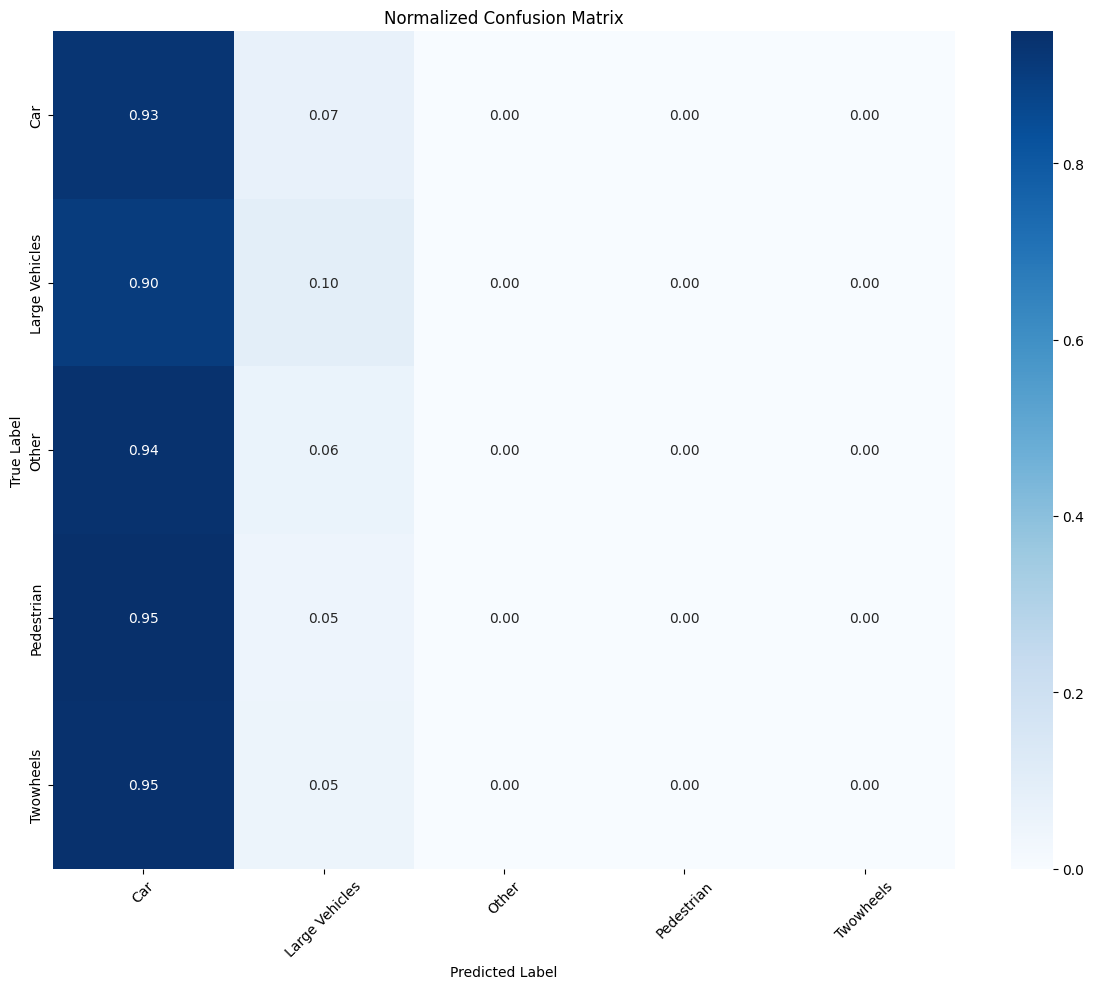

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Get ground truth labels
y_true = features_df['cluster_majority_class']

# If predictions are numeric, convert to string for comparison if needed
if np.issubdtype(onnx_preds.dtype, np.number):
    # Map numeric predictions to class names using the most frequent classes
    class_names = features_df['cluster_majority_class'].value_counts().index.tolist()
    # If model output is class indices, map to class names
    if onnx_preds.max() < len(class_names):
        y_pred = [class_names[i] for i in onnx_preds]
    else:
        y_pred = onnx_preds.astype(str)
else:
    y_pred = onnx_preds

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=class_names))

plt.figure(figsize=(12, 10))
cm_normalized = confusion_matrix(y_true, y_pred, labels=class_names, normalize='true')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---